In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt
import cvxpy as cp
import pandas as pd
from os.path import join
from scipy.spatial.distance import cdist
from scipy.sparse import csgraph
from scipy.stats import skew, kurtosis
from itertools import product
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from nilearn import masking
from nilearn.image import new_img_like
from nilearn.plotting import plot_stat_map, view_img
import os, sys
from config import Config
from pathlib import Path
from nilearn.image import mean_img
from nilearn.image import resample_to_img
import warnings

In [2]:
ses = 1
sub = '04'
runs_to_process = [1, 2]

anat_img = nib.load(f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_2mm.nii.gz')
anat_img = nib.as_closest_canonical(anat_img) #????

base_path = '/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives'

fmt = lambda x: f"{x:.3f}"
fmt_arr = lambda a: np.array2string(np.asarray(a), precision=3, separator=', ', suppress_small=True)

In [3]:
def remove_background(mask, anat_file, bold_data):
    mask_in_run1_img = resample_to_img(source_img=mask, target_img=anat_file, interpolation='nearest', force_resample=True, copy_header=True)
    anat_data = anat_file.get_fdata()
    valid_run1 = np.isfinite(anat_data) & (anat_data != 0)
    mask_in_run1 = mask_in_run1_img.get_fdata().astype(bool)
    combined_mask = mask_in_run1 & valid_run1
    mask_4d = combined_mask[..., np.newaxis]

    bold_data_masked = bold_data * mask_4d
    active_voxels = np.any(bold_data_masked != 0, axis=-1)
    final_mask = active_voxels & combined_mask
    masked_timeseries_3d = np.where(final_mask[..., None], bold_data, 0)

    active_voxels = np.any(masked_timeseries_3d != 0, axis=-1)
    coords = np.array(np.where(active_voxels)).T
    xmin, ymin, zmin = coords.min(axis=0)
    xmax, ymax, zmax = coords.max(axis=0)

    masked_timeseries_3d_cropped = masked_timeseries_3d[xmin:xmax+1, ymin:ymax+1, zmin:zmax+1, :]
    return masked_timeseries_3d_cropped, xmin, ymin, zmin

def save_beta_html(beta_3d, anat_img, bold_img, A, title, fname):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*symmetric_cmap=False.*", category=UserWarning)
        warnings.filterwarnings("ignore", message=".*vmin cannot be chosen when cmap is symmetric.*", category=UserWarning)

    # Keep only finite voxels; set the rest to 0 so we can threshold them away
    finite = np.isfinite(beta_3d)
    beta_filled = np.where(finite, beta_3d, 0.0)

    # Pick a symmetric range from percentiles of finite voxels
    vmax = np.nanpercentile(beta_3d[finite], 99)  # or 97/95 if you prefer
    vmin = np.nanpercentile(beta_3d[finite], 1)
    print("Colormap Range: [", vmax, ",", vmin, "]")

    # Small threshold hides zeros/very small values (the “white” part)
    thr = 1e-6  # or e.g. np.nanpercentile(np.abs(beta_3d[finite]), 90)

    beta_on_anat = nib.Nifti1Image(beta_filled, A, bold_img.header)
    view = view_img(
        beta_on_anat,
        bg_img=anat_img,
        cmap='seismic',
        symmetric_cmap=False,
        vmax=vmax,
        vmin=vmin,
        threshold=thr,          # <- key change
        colorbar=True,
        title=title,
    )
    view.save_as_html(file_name=fname)


def robust_vrange(img, lo=2, hi=98):
    """Percentile-based vmin/vmax on plain ndarray (no masked array)."""
    data = np.asarray(img.get_fdata(), dtype=float)
    data = data[np.isfinite(data)]
    if data.size == 0:
        return 0.0, 1.0
    vmin, vmax = np.percentile(data, [lo, hi])
    return float(vmin), float(vmax)

GLM Overview

In [4]:
glm_dict = np.load('/home/zkavian/thesis_code_git/GLMOutputs-sub04-ses1/TYPED_FITHRF_GLMDENOISE_RR.npy', allow_pickle=True).item()

print("Keys:", list(glm_dict.keys()))
print("betasmd shape:", glm_dict['betasmd'].shape, "\n")

# ---------- Noisepool percentage ----------
noisepool = glm_dict['noisepool'].astype(np.uint8)
coord = np.where(noisepool)
num_voxels = noisepool.size
pct_noise = len(coord[0]) / num_voxels * 100
print(f"Detected Noise Voxels: {fmt(pct_noise)} %")

# ---------- FRAC value summaries ----------
def unique_safely(x):
    if np.ma.isMaskedArray(x):
        return np.unique(x.compressed())
    return np.unique(x)

FRAC = glm_dict['FRACvalue']
all_vals = unique_safely(FRAC)
noisepool_vals = unique_safely(FRAC[coord])

print("Fractional Regularization Level:")
print("  All voxels unique:", fmt_arr(all_vals))
print("  Noisepool voxels unique:", fmt_arr(noisepool_vals))
print()

# ---------- Per-run splits from GLM (shared) ----------
beta = glm_dict['betasmd']
beta_run1, beta_run2 = beta[..., :90], beta[..., 90:]
R2_run1, R2_run2 = glm_dict['R2run'][:,:,:,0], glm_dict['R2run'][:,:,:,1]

def stats_str(x):
    return f"max {fmt(np.nanmax(x))}, min {fmt(np.nanmin(x))}, mean {fmt(np.nanmean(x))}"

print("Beta Value:")
print("  Run1:", stats_str(beta_run1))
print("  Run2:", stats_str(beta_run2))
print()
print("R2 Value:")
print("  Run1:", stats_str(R2_run1))
print("  Run2:", stats_str(R2_run2))
print()

# ---------- % non-NaN (active) voxels ----------
n_total = beta_run1.size
pct_active_run1 = np.count_nonzero(~np.isnan(beta_run1)) / n_total * 100
pct_active_run2 = np.count_nonzero(~np.isnan(beta_run2)) / n_total * 100
print(f"Non-NaN (active) voxels: Run1 {fmt(pct_active_run1)} %, Run2 {fmt(pct_active_run2)} %")

# Beta means (shared computation; used per run below)
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)
beta_mean_run1 = np.nanmean(beta_run1, axis=-1)
beta_mean_run2 = np.nanmean(beta_run2, axis=-1)

# Consistent color scaling across both runs
both_beta_vals = np.concatenate([np.ravel(beta_mean_run1), np.ravel(beta_mean_run2)])
vmax_all = np.nanpercentile(np.abs(both_beta_vals), 99)
vmin_all = -vmax_all

Keys: ['HRFindex', 'HRFindexrun', 'glmbadness', 'pcvoxels', 'pcnum', 'xvaltrend', 'noisepool', 'pcregressors', 'betasmd', 'R2', 'R2run', 'rrbadness', 'FRACvalue', 'scaleoffset', 'meanvol']
betasmd shape: (69, 92, 73, 180) 

Detected Noise Voxels: 29.452 %
Fractional Regularization Level:
  All voxels unique: [0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
 0.65, 0.7 , 0.75, 1.  ]
  Noisepool voxels unique: [0.05, 0.1 , 0.15, 0.2 ]

Beta Value:
  Run1: max 12023.069, min -2978.961, mean 0.009
  Run2: max 2439.105, min -4227.346, mean 0.026

R2 Value:
  Run1: max 37.737, min -6.138, mean 4.646
  Run2: max 61.058, min -21.858, mean 5.038

Non-NaN (active) voxels: Run1 45.410 %, Run2 45.410 %


(-40.0, 40.0)

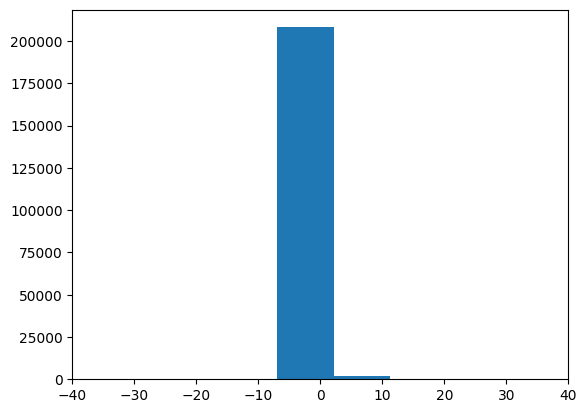

In [35]:
plt.figure()
plt.hist(beta_mean_run2.ravel(), bins=10)
plt.xlim([-40, 40])

In [40]:
np.nanstd(beta_mean_run1)
tmp = beta_mean_run1[beta_mean_run1>=10]
tmp.shape

(220,)

In [43]:
filtered_image_cleaned = np.full(beta_mean_run1.shape, np.nan, dtype=float)
valid_mask = np.isfinite(beta_mean_run1) & (beta_mean_run1 >= 3)
filtered_image_cleaned[valid_mask] = beta_mean_run1[valid_mask]

run = 1
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
A = bold_img.affine.copy()
A[:3, 3] = A[:3, 3] + A[:3, :3] @ np.array([xmin, ymin, zmin], dtype=float)
save_beta_html(filtered_image_cleaned, anat_img, bold_img, A, f"All Beta", f"test_sub{sub}_ses{ses}_run{run}.html")


Colormap Range: [ 30.174674606323418 , 3.021697990894318 ]


BOLD Image and Masked BOLD Image on the Brain Anatomy

In [ ]:
data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
bold_img = nib.load(BOLD_path_org)
A = bold_img.affine.copy()
A[:3, 3] = A[:3, 3] + A[:3, :3] @ np.array([xmin, ymin, zmin], dtype=float)

In [5]:
warnings.filterwarnings("ignore", message=".*'partition' will ignore the 'mask' of the MaskedArray.*", category=UserWarning, module=r"numpy\._core\.fromnumeric")

for run in runs_to_process:
    print(f"\n===== Processing run {run} =====")

    # Load BOLD for this run
    data_name = f'sub-pd0{sub}_ses-{ses}_run-{run}_task-mv_bold_corrected_smoothed_reg_2mm.nii.gz'
    BOLD_path_org = join(base_path, f'sub-pd0{sub}', f'ses-{ses}', 'func', data_name)
    bold_img = nib.load(BOLD_path_org)
    func_img = nib.as_closest_canonical(bold_img)
    bold_data = bold_img.get_fdata()
    print("Raw BOLD Data Shape: ", bold_data.shape)

    # Quick overlay of mean BOLD on anatomy (saved)
    mean_bold = mean_img(bold_img, copy_header=True) 
    vmin, vmax = robust_vrange(mean_bold)
    view = view_img(mean_bold, bg_img=anat_img, title='BOLD Image on Anatomic Brain', threshold=None, symmetric_cmap=False, vmin=vmin, vmax=vmax, dim=0)
    view.save_as_html(f"BOLD_data_on_Anat_sub{sub}_ses{ses}_run{run}.html")

    # Mask path (generalized)
    mask_path = f'/mnt/TeamShare/Data_Masterfile/H20-00572_All-Dressed/PRECISIONSTIM_PD_Data_Results/fMRI_preprocessed_data/Rev_pipeline/derivatives/sub-pd0{sub}/ses-{ses}/anat/sub-pd0{sub}_ses-{ses}_T1w_brain_mask.nii.gz'
    mask = nib.load(mask_path)

    # Remove background and crop
    bold_data_masked, xmin, ymin, zmin = remove_background(mask, anat_img, bold_data)
    print("Masked shape:", bold_data_masked.shape)

    # Adjust affine to account for cropping
    A = bold_img.affine.copy()
    A[:3, 3] = A[:3, 3] + A[:3, :3] @ np.array([xmin, ymin, zmin], dtype=float)
    bold_data_masked_img = nib.Nifti1Image(bold_data_masked, A, bold_img.header)

    # Overlay masked mean BOLD on anatomy (saved)
    mean_bold_masked = mean_img(bold_data_masked_img, copy_header=True)  # fixes FutureWarning
    vmin_m, vmax_m = robust_vrange(mean_bold_masked)
    view = view_img(mean_bold_masked, bg_img=anat_img, title='Masked BOLD Image on Anatomic Brain')
    view.save_as_html(f"Masked_BOLD_data_on_Anat_sub{sub}_ses{ses}_run{run}.html")

    # Noisepool overlay (per run file)
    noisepool_img = nib.Nifti1Image(noisepool, A, bold_img.header)
    vmax_np = float(np.nanmax(np.asarray(noisepool, dtype=float)))
    view = view_img(noisepool_img, bg_img=anat_img, threshold=0.5, title='Noisepool voxels', resampling_interpolation='nearest', 
                    symmetric_cmap=False, vmin=0.0, vmax=vmax_np)
    view.save_as_html(file_name=f"Noisepool_Mask_on_the_brain_sub{sub}_ses{ses}_run{run}.html")



===== Processing run 1 =====
Raw BOLD Data Shape:  (90, 128, 85, 850)
Masked shape: (69, 92, 73, 850)

===== Processing run 2 =====
Raw BOLD Data Shape:  (90, 128, 85, 850)
Masked shape: (69, 92, 73, 850)


Plot Beta Values on the Brain

In [6]:
warnings.filterwarnings(
    "ignore",
    message=".*symmetric_cmap=False.*",
    category=UserWarning
)
warnings.filterwarnings(
    "ignore",
    message=".*vmin cannot be chosen when cmap is symmetric.*",
    category=UserWarning
)
warnings.filterwarnings(
    "ignore",
    message=".*Non-finite values detected.*",
    category=UserWarning
)
    
for run in runs_to_process:
    if run == 1:
        beta_mean_this = beta_mean_run1
        R2_this = R2_run1
    else:
        beta_mean_this = beta_mean_run2
        R2_this = R2_run2
    
    save_beta_html(beta_mean_this, anat_img, bold_img, A, f"All Beta", f"Beta_all_voxels_sub{sub}_ses{ses}_run{run}.html")
    save_beta_html(np.abs(beta_mean_this), anat_img, bold_img, A, f"All Abs Beta", f"Beta_abs_all_voxels_sub{sub}_ses{ses}_run{run}.html")

    # Histogram & binning based on R2
    bin_width = 10
    X = R2_this.ravel()
    bins = np.arange(np.nanmin(X), np.nanmax(X) + bin_width, bin_width)

    plt.figure(figsize=(8,8))
    n, bins, patches = plt.hist(X, bins=bins)
    plt.tight_layout()
    plt.savefig(f"R2_hist_sub{sub}_ses{ses}_run{run}.png", dpi=150)
    plt.close()
    print(f"Histogram Bins (run {run}): {bins}, Number of bins: {int(len(patches))}")

    # Make per-bin beta masks & save
    n_bins = int(len(patches))
    for i in range(n_bins):
        low, high = float(bins[i]), float(bins[i+1])
        if i < n_bins - 1:
            mask_i = (R2_this >= low) & (R2_this < high)
        else:
            mask_i = (R2_this >= low) & (R2_this <= high)

        mask_beta_3d = np.full(beta_mean_this.shape, np.nan, dtype=float)
        mask_beta_3d[mask_i] = beta_mean_this[mask_i]
        c_min, c_max = np.nanmin(mask_beta_3d), np.nanmax(mask_beta_3d)
        print(f"run {run} bin {i+1}: min {c_min}, max {c_max}, number of voxels: {n[i]}")

        finite = np.isfinite(mask_beta_3d)
        beta_filled = np.where(finite, mask_beta_3d, 0.0)
        vmax = np.nanpercentile(mask_beta_3d[finite], 99)
        vmin = np.nanpercentile(mask_beta_3d[finite], 1)
        thr = 1e-6 

        beta_on_anat = nib.Nifti1Image(mask_beta_3d, A, bold_img.header)
        view = view_img(
            beta_on_anat,
            bg_img=anat_img,
            title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]',
            colorbar=True,
            cmap='seismic',
            vmin=vmin,
            vmax=vmax,
            threshold=thr
        )
        view.save_as_html(file_name=f'Beta_mask_bin{i+1}_sub{sub}_ses{ses}_run{run}.html')


Colormap Range: [ 2.6614635 , -2.8885217 ]
Colormap Range: [ 4.128598 , 0.001221316 ]
Histogram Bins (run 1): [-6.13777208  3.86222792 13.86222792 23.86222792 33.86222792 43.86222792], Number of bins: 5
run 1 bin 1: min -7.857098579406738, max 13.206343650817871, number of voxels: 135289.0
run 1 bin 2: min -42.066619873046875, max 118.27816772460938, number of voxels: 65027.0
run 1 bin 3: min -18.964879989624023, max 58.21822738647461, number of voxels: 9345.0
run 1 bin 4: min -5.946022033691406, max 11.683488845825195, number of voxels: 752.0
run 1 bin 5: min -3.1202824115753174, max 10.34862995147705, number of voxels: 13.0
Colormap Range: [ 2.1499376 , -1.8925105 ]
Colormap Range: [ 2.94306 , 0.0012415185 ]
Histogram Bins (run 2): [-21.85840607 -11.85840607  -1.85840607   8.14159393  18.14159393
  28.14159393  38.14159393  48.14159393  58.14159393  68.14159393], Number of bins: 9
run 2 bin 1: min -1.5923792123794556, max 1.0531998872756958, number of voxels: 29.0
run 2 bin 2: min -2

In [20]:
import numpy as np
from scipy.ndimage import median_filter

def hampel_filter_image(image, R2_run, window_size, threshold_factor):
    filtered_image = np.copy(image).astype(float)
    rows, cols, depth = image.shape

    for r in range(window_size // 2, rows - window_size // 2):
        for c in range(window_size // 2, cols - window_size // 2):
            for d in range(window_size // 2, depth - window_size //2):
                window = image[r - window_size // 2 : r + window_size // 2 + 1,
                               c - window_size // 2 : c + window_size // 2 + 1,
                               d - window_size // 2 : d + window_size // 2 + 1]

                window_median = np.nanmedian(window)
                mad = np.nanmedian(np.abs(window - window_median))
                scaled_mad = 1.4826 * mad # Assuming Gaussian data for scaling factor

                if image[r, c, d] is not None:
                    if np.abs(image[r, c, d] - window_median) > threshold_factor * scaled_mad:
                        filtered_image[r, c, d] = np.nan
                        R2_run[r, c, d] = np.nan

    return filtered_image, R2_run


def apply_hf_on_image(beta_mean_run1, beta_mean_run2, R2_run1, R2_run2, sub, run, ses, window_size):
    print(beta_mean_run1.shape)
    filtered_image1, filtered_R2_run1 = hampel_filter_image(beta_mean_run1, R2_run1, window_size=window_size, threshold_factor=3)
    filtered_image2, filtered_R2_run2 = hampel_filter_image(beta_mean_run2, R2_run2, window_size=window_size, threshold_factor=3)

    tmp = beta_mean_run1[~np.isnan(beta_mean_run1)]
    print(tmp.shape)

    tmp2 = filtered_image1[~np.isnan(filtered_image1)]
    print(tmp2.shape)

    print(f"{(tmp.shape[0]-tmp2.shape[0])/tmp.shape[0]*100}% voxels is removed!")

    warnings.filterwarnings(
        "ignore",
        message=".*symmetric_cmap=False.*",
        category=UserWarning
    )
    warnings.filterwarnings(
        "ignore",
        message=".*vmin cannot be chosen when cmap is symmetric.*",
        category=UserWarning
    )
    warnings.filterwarnings(
        "ignore",
        message=".*Non-finite values detected.*",
        category=UserWarning
    )
        
    for run in runs_to_process:
        if run == 1:
            beta_mean_this = filtered_image1
            R2_this = filtered_R2_run1
        else:
            beta_mean_this = filtered_image2
            R2_this = filtered_R2_run2

        # Histogram & binning based on R2
        bin_width = 10
        X = R2_this.ravel()
        bins = np.arange(np.nanmin(X), np.nanmax(X) + bin_width, bin_width)

        plt.figure(figsize=(8,8))
        n, bins, patches = plt.hist(X, bins=bins)
        plt.tight_layout()
        plt.savefig(f"HF_R2_hist_sub{sub}_ses{ses}_run{run}_window{window_size}.png", dpi=150)
        plt.close()
        print(f"HF_Histogram Bins (run {run}): {bins}, Number of bins: {int(len(patches))}")

        # Make per-bin beta masks & save
        n_bins = int(len(patches))
        for i in range(n_bins):
            low, high = float(bins[i]), float(bins[i+1])
            if i < n_bins - 1:
                mask_i = (R2_this >= low) & (R2_this < high)
            else:
                mask_i = (R2_this >= low) & (R2_this <= high)

            mask_beta_3d = np.full(beta_mean_this.shape, np.nan, dtype=float)
            mask_beta_3d[mask_i] = beta_mean_this[mask_i]
            c_min, c_max = np.nanmin(mask_beta_3d), np.nanmax(mask_beta_3d)
            print(f"run {run} bin {i+1}: min {c_min}, max {c_max}, number of voxels: {n[i]}")

            finite = np.isfinite(mask_beta_3d)
            beta_filled = np.where(finite, mask_beta_3d, 0.0)
            vmax = np.nanpercentile(mask_beta_3d[finite], 99)
            vmin = np.nanpercentile(mask_beta_3d[finite], 1)
            thr = 1e-6 

            if c_min != c_max:
                beta_on_anat = nib.Nifti1Image(mask_beta_3d, A, bold_img.header)
                view = view_img(
                    beta_on_anat,
                    bg_img=anat_img,
                    title=f'bin {i+1},  [{fmt(low)},{fmt(high)}]',
                    colorbar=True,
                    cmap='seismic',
                    vmin=vmin,
                    vmax=vmax,
                    threshold=thr
                )
                view.save_as_html(file_name=f'HF_Beta_mask_bin{i+1}_sub{sub}_ses{ses}_run{run}_window{window_size}.html')


    return filtered_image1, filtered_R2_run1, filtered_image2, filtered_R2_run2

In [25]:
def clean_and_analysis_output(beta_mean, filtered_image, filtered_R2, sub, run, ses, window_size):
    # removing nan value from the BOLD image
    num_voxel1 = beta_mean.size
    valid_mask = np.isfinite(beta_mean)
    filtered_image_cleaned = beta_mean[valid_mask]  # vector (if you still want stats)
    filtered_image_cleaned_3d = np.full(beta_mean.shape, np.nan, dtype=float)
    filtered_image_cleaned_3d[valid_mask] = filtered_image_cleaned
    tmp = filtered_image_cleaned_3d[~np.isnan(filtered_image_cleaned_3d)]
    num_voxel2 = tmp.shape[0]
    filtered_R2_cleaned = np.full(filtered_R2.shape, np.nan, dtype=float)
    filtered_R2_cleaned[valid_mask] = filtered_R2[valid_mask]

    save_beta_html(filtered_image_cleaned_3d, anat_img, bold_img, A, f"All Beta", f"Final_voxels_(without_nan)_sub{sub}_ses{ses}_run{run}_window{window_size}.html")
    print(f"{abs(num_voxel2-num_voxel1)/num_voxel1*100}% of voxles has a NaN beta value.({num_voxel2} of {num_voxel1})")

    # removing nan value from the BOLD image (after HF)
    valid_mask = np.isfinite(filtered_image)
    beta_mean_cleaned2 = filtered_image[valid_mask]  # vector (if you still want stats)
    filtered_image_cleaned = np.full(filtered_image.shape, np.nan, dtype=float)
    filtered_image_cleaned[valid_mask] = beta_mean_cleaned2
    tmp = filtered_image_cleaned[~np.isnan(filtered_image_cleaned)]
    num_voxel3 = tmp.shape[0]
    filtered_R2_cleaned2 = np.full(filtered_R2_cleaned.shape, np.nan, dtype=float)
    filtered_R2_cleaned2[valid_mask] = filtered_R2_cleaned[valid_mask]
    print(f"{abs(num_voxel3-num_voxel1)/num_voxel1*100}% of voxles has a NaN beta value or are considered as outlier.({num_voxel3} of {num_voxel1})")
    print(f"{abs(num_voxel3-num_voxel2)/num_voxel2*100}% of nonnan voxles are considered as outlier.({num_voxel3} of {num_voxel2})")
    save_beta_html(filtered_image_cleaned, anat_img, bold_img, A, f"All Beta", f"Final_voxels_(without_nan_outlier)_sub{sub}_ses{ses}_run{run}_window{window_size}.html")

    # Histogram & binning based on R2
    bin_width = 10
    X = filtered_R2_cleaned2.ravel()
    bins = np.arange(np.nanmin(X), np.nanmax(X) + bin_width, bin_width)
    n, bins, patches = plt.hist(X, bins=bins)
    idx0 = np.searchsorted(bins, 0.0, side='left')
    if idx0 < len(bins) - 1:
        low = float(bins[idx0])
    else:
        low = 0.0
    mask = (filtered_R2_cleaned2 >= low)
    mask_beta_3d = np.full(filtered_R2_cleaned2.shape, np.nan, dtype=float)
    mask_beta_3d[mask] = filtered_R2_cleaned2[mask]
    mask_beta_3d_cleaned = mask_beta_3d[~np.isnan(mask_beta_3d)]
    num_voxel4 = mask_beta_3d_cleaned.shape[0]
    print(f"{abs(num_voxel4-num_voxel1)/num_voxel1*100}% of voxles has a NaN beta value, are considered as outlier, have low R2.({num_voxel4} of {num_voxel1})")
    print(f"{abs(num_voxel4-num_voxel3)/num_voxel3*100}% of selected voxles have low R2.({num_voxel4} of {num_voxel3})")
    save_beta_html(mask_beta_3d, anat_img, bold_img, A, f"All Beta", f"Final_voxels_(without_nan_outlier_low_R2)_sub{sub}_ses{ses}_run{run}_window{window_size}.html")
    return

(69, 92, 73)


/tmp/ipykernel_215053/2308745885.py:15: RuntimeWarning: All-NaN slice encountered
  window_median = np.nanmedian(window)
/tmp/ipykernel_215053/2308745885.py:16: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(window - window_median))


(210434,)
(192800,)
8.37982455306652% voxels is removed!
HF_Histogram Bins (run 1): [-6.06684732  3.93315268 13.93315268 23.93315268 33.93315268], Number of bins: 4
run 1 bin 1: min -2.242952823638916, max 3.0170810222625732, number of voxels: 134846.0
run 1 bin 2: min -10.65752124786377, max 10.369962692260742, number of voxels: 39729.0
run 1 bin 3: min -10.36491870880127, max 7.629574298858643, number of voxels: 3662.0
run 1 bin 4: min -1.1207144260406494, max 2.289811849594116, number of voxels: 232.0
HF_Histogram Bins (run 2): [-20.57930756 -10.57930756  -0.57930756   9.42069244  19.42069244
  29.42069244  39.42069244  49.42069244  59.42069244], Number of bins: 8
run 2 bin 1: min -0.6440090537071228, max 0.23806732892990112, number of voxels: 10.0
run 2 bin 2: min -0.8958060145378113, max 1.1886523962020874, number of voxels: 308.0
run 2 bin 3: min -3.093092441558838, max 5.473191261291504, number of voxels: 163626.0
run 2 bin 4: min -7.299222946166992, max 10.113801002502441, numb

/tmp/ipykernel_215053/2308745885.py:15: RuntimeWarning: All-NaN slice encountered
  window_median = np.nanmedian(window)
/tmp/ipykernel_215053/2308745885.py:16: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(window - window_median))


(210434,)
(184020,)
12.552154119581434% voxels is removed!
HF_Histogram Bins (run 1): [-6.06684732  3.93315268 13.93315268 23.93315268 33.93315268], Number of bins: 4
run 1 bin 1: min -2.242952823638916, max 3.0170810222625732, number of voxels: 134846.0
run 1 bin 2: min -10.65752124786377, max 10.369962692260742, number of voxels: 39729.0
run 1 bin 3: min -10.36491870880127, max 7.629574298858643, number of voxels: 3662.0
run 1 bin 4: min -1.1207144260406494, max 2.289811849594116, number of voxels: 232.0
HF_Histogram Bins (run 2): [-20.57930756 -10.57930756  -0.57930756   9.42069244  19.42069244
  29.42069244  39.42069244  49.42069244  59.42069244], Number of bins: 8
run 2 bin 1: min -0.6440090537071228, max 0.23806732892990112, number of voxels: 10.0
run 2 bin 2: min -0.8958060145378113, max 1.1886523962020874, number of voxels: 308.0
run 2 bin 3: min -3.093092441558838, max 5.473191261291504, number of voxels: 163626.0
run 2 bin 4: min -7.299222946166992, max 10.113801002502441, nu

/tmp/ipykernel_215053/2308745885.py:15: RuntimeWarning: All-NaN slice encountered
  window_median = np.nanmedian(window)
/tmp/ipykernel_215053/2308745885.py:16: RuntimeWarning: All-NaN slice encountered
  mad = np.nanmedian(np.abs(window - window_median))


(210434,)
(181043,)
13.966849463489739% voxels is removed!
HF_Histogram Bins (run 1): [-6.06684732  3.93315268 13.93315268 23.93315268 33.93315268], Number of bins: 4
run 1 bin 1: min -2.242952823638916, max 3.0170810222625732, number of voxels: 134846.0
run 1 bin 2: min -10.65752124786377, max 10.369962692260742, number of voxels: 39729.0
run 1 bin 3: min -10.36491870880127, max 7.629574298858643, number of voxels: 3662.0
run 1 bin 4: min -1.1207144260406494, max 2.289811849594116, number of voxels: 232.0
HF_Histogram Bins (run 2): [-20.57930756 -10.57930756  -0.57930756   9.42069244  19.42069244
  29.42069244  39.42069244  49.42069244  59.42069244], Number of bins: 8
run 2 bin 1: min -0.6440090537071228, max 0.23806732892990112, number of voxels: 10.0
run 2 bin 2: min -0.8958060145378113, max 1.1886523962020874, number of voxels: 308.0
run 2 bin 3: min -3.093092441558838, max 5.473191261291504, number of voxels: 163626.0
run 2 bin 4: min -7.299222946166992, max 10.113801002502441, nu

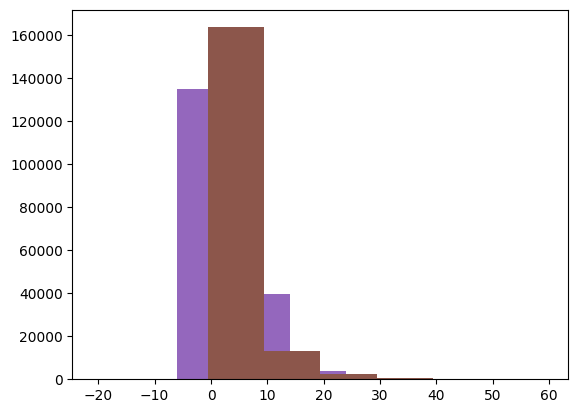

In [28]:
filtered_image1, filtered_R2_run1, filtered_image2, filtered_R2_run2 = apply_hf_on_image(beta_mean_run1, beta_mean_run2, R2_run1, R2_run2, sub, run, ses, window_size=3)
clean_and_analysis_output(beta_mean_run1, filtered_image1, filtered_R2_run1, sub, 1, ses, window_size=3)
clean_and_analysis_output(beta_mean_run2, filtered_image2, filtered_R2_run2, sub, 2, ses, window_size=3)

filtered_image1, filtered_R2_run1, filtered_image2, filtered_R2_run2 = apply_hf_on_image(beta_mean_run1, beta_mean_run2, R2_run1, R2_run2, sub, run, ses, window_size=5)
clean_and_analysis_output(beta_mean_run1, filtered_image1, filtered_R2_run1, sub, 1, ses, window_size=5)
clean_and_analysis_output(beta_mean_run2, filtered_image2, filtered_R2_run2, sub, 2, ses, window_size=5)

filtered_image1, filtered_R2_run1, filtered_image2, filtered_R2_run2 = apply_hf_on_image(beta_mean_run1, beta_mean_run2, R2_run1, R2_run2, sub, run, ses, window_size=7)
clean_and_analysis_output(beta_mean_run1, filtered_image1, filtered_R2_run1, sub, 1, ses, window_size=7)
clean_and_analysis_output(beta_mean_run2, filtered_image2, filtered_R2_run2, sub, 2, ses, window_size=7)

In [29]:
import os
import shutil

def copy_html_files(src_folder, dst_folder):
    # Make sure the destination folder exists
    os.makedirs(dst_folder, exist_ok=True)

    # Walk through the source folder
    for root, dirs, files in os.walk(src_folder):
        for file in files:
            if file.endswith(".html"):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(dst_folder, file)

                # Copy the file
                shutil.copy2(src_path, dst_path)
                print(f"Copied: {src_path} -> {dst_path}")

# Example usage:
src_folder = "/home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new"   # Change this to your folder
dst_folder = "/mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/"  # Change this to where you want files saved

copy_html_files(src_folder, dst_folder)


Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin7_sub04_ses1_run2_window7.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/HF_Beta_mask_bin7_sub04_ses1_run2_window7.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin8_sub04_ses1_run2.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/HF_Beta_mask_bin8_sub04_ses1_run2.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/Final_voxels_(without_nan_outlier_low_R2)_sub04_ses1_run2_window5.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/Final_voxels_(without_nan_outlier_low_R2)_sub04_ses1_run2_window5.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin3_sub04_ses1_run1_window5.html -> /mnt/TeamShare/Data_Masterfile/Zahra-Thesis-Data/Newfolder/HF_Beta_mask_bin3_sub04_ses1_run1_window5.html
Copied: /home/zkavian/thesis_code_git/Optim_fMRI/Optim_fMRI_new/HF_Beta_mask_bin9_sub04_